# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Чтобы сдать проект успешно, нужно довести *F1*-меру до 0.59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Технический блок импортов и глобальных параметров.

Сразу объявим переменную is_final для обозначения финальной версии, где все долгие расчеты отключены и уже вписаны оптимальные параметры, иначе на сервере практикума это все будет год считаться =(


In [1]:
is_final = True
n_iter = 500
n_trials = 50000

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
# !{sys.executable} -m pip install -U seaborn --quiet --default-timeout=100 -i https://pypi.tuna.tsinghua.edu.cn/simple
# !{sys.executable} -m pip install -U xgboost --quiet --default-timeout=100 -i https://pypi.tuna.tsinghua.edu.cn/simple
# !{sys.executable} -m pip install -U sklearn --quiet --default-timeout=100 -i https://pypi.tuna.tsinghua.edu.cn/simple
# !{sys.executable} -m pip install -U pandas-profiling --quiet --default-timeout=100 -i https://pypi.tuna.tsinghua.edu.cn/simple
#!{sys.executable} -m pip install -U pandas-profiling[notebook] --quiet
#!jupyter nbextension enable --py widgetsnbextension

import six
sys.modules['sklearn.externals.six'] = six
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, \
    neighbors, naive_bayes, svm, set_config, pipeline, impute, manifold, feature_selection, inspection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
import xgboost as xgb
import lightgbm as lgb
import optuna
import time
from typing import Union, Any
from tempfile import mkdtemp
cachedir = mkdtemp()

set_config(display="diagram")
xgb.set_config(verbosity=0)

sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

random_state = 2077
np.random.seed(seed=random_state)

timeout = 60*60

Загрузка файла и ознакомление с содержимым.

In [3]:
filename = 'Churn.csv'
file_path = 'H:/Google_d/2021_ШАД/Yandex - project 7/'
try:
    df = pd.read_csv('/datasets/' + filename, sep=',', index_col=0)  # Серверный путь
    print('Загружено с сервера')
except:
    try:
        df = pd.read_csv(file_path + filename, sep=',', index_col=0)  # Локальный путь
        print('Загружено с локального диска')
    except:
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            df = pd.read_csv('/content/drive/MyDrive/2021_ШАД/Yandex - project 6/' + filename, sep=',')  # Локальный путь
            print('Загружено с гугл-диска')
        except: 1;
df.columns = df.columns.str.lower()
display(df.info())

Загружено с локального диска
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       10000 non-null  int64  
 1   surname          10000 non-null  object 
 2   creditscore      10000 non-null  int64  
 3   geography        10000 non-null  object 
 4   gender           10000 non-null  object 
 5   age              10000 non-null  int64  
 6   tenure           9091 non-null   float64
 7   balance          10000 non-null  float64
 8   numofproducts    10000 non-null  int64  
 9   hascrcard        10000 non-null  int64  
 10  isactivemember   10000 non-null  int64  
 11  estimatedsalary  10000 non-null  float64
 12  exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


None

In [4]:
%matplotlib inline
customerid = df.columns[0]
surname = df.columns[1]
creditscore = df.columns[2]
geography = df.columns[3]
gender = df.columns[4]
age = df.columns[5]
tenure = df.columns[6]
balance = df.columns[7]
numofproducts = df.columns[8]
hascrcard = df.columns[9]
isactivemember = df.columns[10]
estimatedsalary = df.columns[11]
exited = df.columns[12]

features = 'features'
targets = 'targets'

# EDA

Сразу запустим профайлинг, чтобы быстренько оценить, что у нас есть.

In [5]:
pfr = pandas_profiling.ProfileReport(df)
pfr.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Дубликатов нет.

Выводы по индивидуальному рассмотрению:
- все значения RowNumber и customerid полностью уникальны, поэтому бесполезны при моделировании
- surname не полностью уникальны, но имеют огромное количество категориальных значений (около 3к). Бесполезно
- creditscore - распределение почти нормальное. Есть тяжелый хвост - часто встречающееся одно значение
- geography - категориальная, всего 3 региона
- gender - категориальная, 2 значения
- age - распределение почти нормальное, значения адекватные. Но распределение скошено вбок, можно попробовать привести к нормальному виду через логарифм
- tenure (сколько лет человек является клиентом банка) - значения от 0 до 10 и есть пропущенные значения. Распределение однородное с большими провалами на 0 и на 10 годах. Надо как-то обработать пропуски
- balance (баланс на счёте) - распределение почти нормальное, но с большим количеством нулей (нули - 36% всех значений)
- numofproducts (количество продуктов банка, используемых клиентом) - значения от 1 до 4
- hascrcard, isactivemember - по 2 категории
- estimatedsalary - распределение практически однородное
- exited - целевая переменная - 2 категории, дисбаланс 8000 нулей / 2000 единиц

Выводы по парному рассмотрению - высокая корреляция (коэффициент phik):
- баланса и региона
- количества продуктов и баланса (отрицательный коэффициент Пирсона)
- целевой переменной и: возраста (положительный), количества продуктов (явно нелинейный), активности (отрицательный)

Сильных линейных корреляций (в частности таких, которые можно считать утечкой) нет.

Рассмотрим результаты более подробно.

Вообще-то тут надо бы строить боксплоты, но большое количество нулевых значений делает медиану неадекватной.

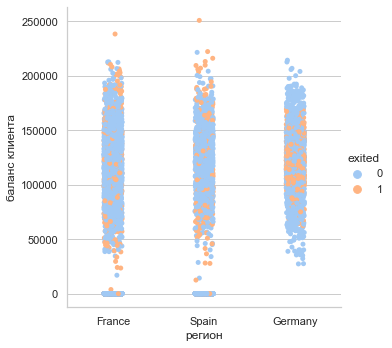

In [6]:
sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_style("whitegrid")
ax = sns.catplot(data=df, hue=exited, x=geography, y=balance, palette='pastel')
ax.set(xlabel='регион', ylabel='баланс клиента');

Видим, что корреляция между балансом и регионом связана с тем, что в Германии почему-то нет клиентов с нулевым балансом, а в остальных регионах есть. Может, какая-то особенность законодательства Германии? В общем, эта корреляция нам не помешает.

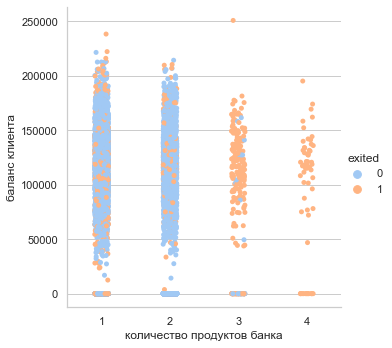

In [7]:
sns.set_style("whitegrid")
ax = sns.catplot(data=df, hue=exited, x=numofproducts, y=balance, palette='pastel')
ax.set(xlabel='количество продуктов банка', ylabel='баланс клиента');

Кажется, что, чем больше продуктов, тем меньше дисперсия разброса. И тем меньше шанс покидания клиентом банка (хотя для 1 и 2 неочевидно).

Средний возраст покинувших банк 44.8379970544919
Средний возраст не покинувших банк 37.40838879819164


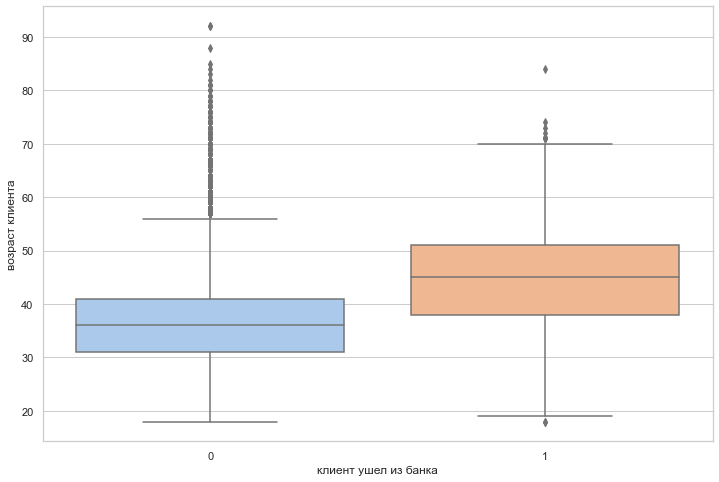

In [8]:
sns.set_style("whitegrid")
ax = sns.boxplot(data=df, x=exited, y=age, palette='pastel')
ax.set(xlabel='клиент ушел из банка', ylabel='возраст клиента');
print('Средний возраст покинувших банк', df[df[exited] == 1][age].mean())
print('Средний возраст не покинувших банк', df[df[exited] == 0][age].mean())

Странно выглядит, что уходят более старшие клиенты (и медиана, и среднее). Я бы предположил, что молодежь должна искать новые банки.

In [9]:
df.pivot_table(index=exited, columns=isactivemember, values=age, aggfunc='count')

isactivemember     0     1
exited                    
0               3547  4416
1               1302   735

Видим, что среди оставшихся клиентов примерно половина активны, а половина - нет.
Из ушедших - активных примерно в два раза меньше.

Попробуем привести распределения к нормальным и посмотрим, для каких это работает.

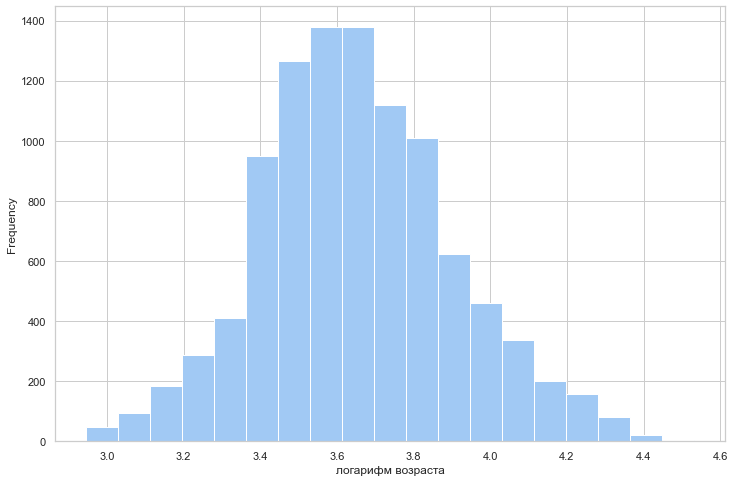

In [10]:
a = pd.Series(np.log1p(df[age]))
a.plot(kind='hist', bins=19).set(xlabel='логарифм возраста');

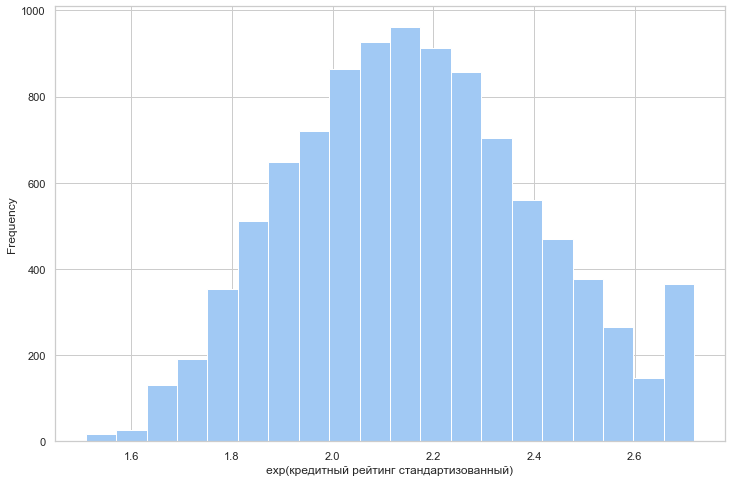

In [11]:
a = pd.Series(np.exp(df[creditscore]/850))
a.plot(kind='hist', bins=20).set(xlabel='exp(кредитный рейтинг стандартизованный)');

Итак, наши задачи:
- отбросить ненужные столбцы (customerid)
- заполнить пропуски в столбце tenure
- применить OHE к категориальным признакам, которые еще не закодированы
- применить стандартизацию к количественным признакам для линейных моделей
- (опционально) привести распределения к нормальным
- ввести новые категориальные признаки, например, для строк с балансом, равным нулю

## Исследование задачи

### Выборки

Делаем обучающую и тестовую выборку.

Валидационную не делаем - будем использовать кросс-валидацию.

In [12]:
train = dict()
test = dict()
targets_df = df[exited]
features_df = df[df.columns.drop(exited)]

train[features], test[features], train[targets], test[targets] = model_selection.train_test_split(
            features_df,
            targets_df, 
            test_size = 0.25, 
            random_state=random_state, 
            shuffle=True,
            stratify=targets_df
            )
for i in [train[features], test[features], train[targets], test[targets]]:
    display(i.shape)

(7500, 12)

(2500, 12)

(7500,)

(2500,)

### Визуализация методом TSNE

Сначала оценим, разделима ли выборка визуально после преобразования TSNE.

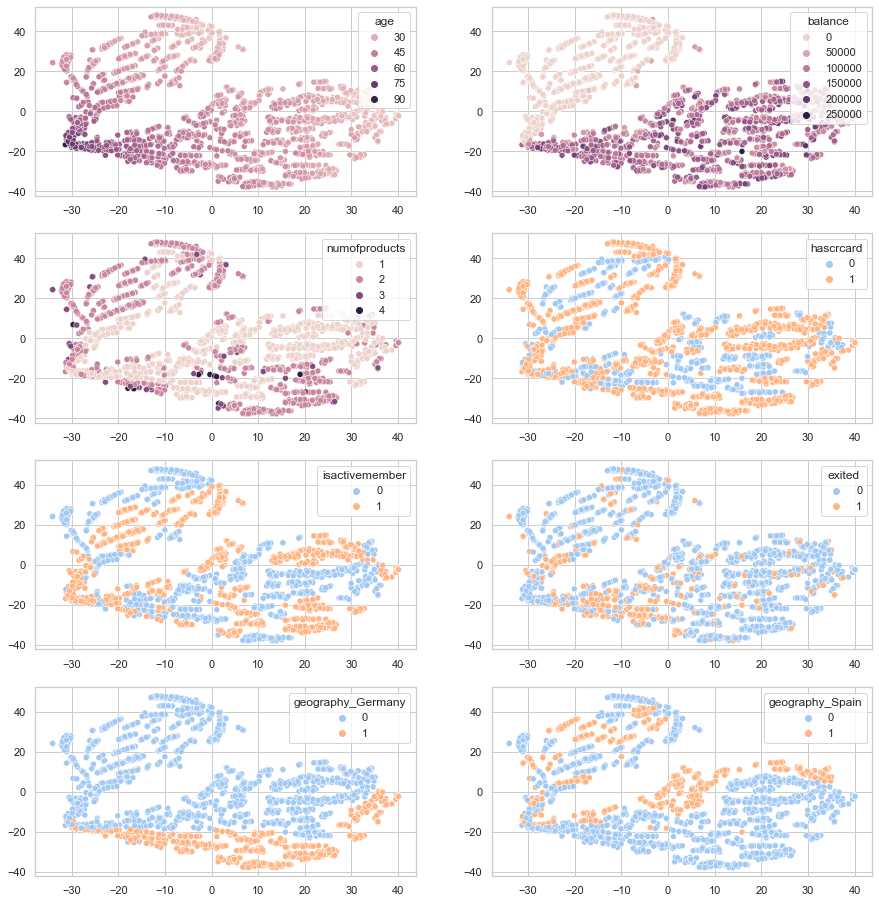

In [13]:
frac = 0.05
if is_final: frac = 0.15

tmp = pd.get_dummies(
    df.drop(columns=[surname, customerid, tenure, gender, creditscore, estimatedsalary]).dropna(), 
    drop_first=True
    ).sample(frac=0.2, random_state=random_state)

s = preprocessing.MinMaxScaler()
arr = s.fit_transform(tmp)
tmp2 = pd.DataFrame(arr, columns=tmp.columns)
for i in [balance, age]:
    tmp2[i] = tmp2[i] * 4 # пытаемся уравновесить количественные и категориальные признаки
    
# увеличим значимость некоторых признаков, которые хорошо себя показали при моделировании
tmp2[age] = tmp2[age] * 4
tmp2[numofproducts] = tmp2[numofproducts] * 3
    
tsne = manifold.TSNE(n_components=2, perplexity=50, learning_rate='auto', init='random', random_state=random_state)
a = tsne.fit_transform(tmp2.drop(columns=[exited]))

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15,16))

for col, i, ax in zip(tmp.columns, range(len(tmp.columns)), axes.flat):
    sns.scatterplot(x=a[:,0], y=a[:,1], hue=tmp[col], ax=ax)
plt.show()

Нет, целевой признак никак не хочет проявляться. Я около получаса крутил ручки, и так и не смог сделать, чтобы целевой признак кластеризовался. Но видна сильная связь с возрастом - уходят клиенты постарше. Кроме того, видна антикорреляция с активностью клиента.

Вероятно, из этого следует невозможность получения идеальных метрик качества. Будем к этому готовы.

### Вспомогательный класс и функция

К моему удивлению в sklearn невозможно задать порог принятия решения классификатором! Абсурд! Пришлось потратить полдня на написание вот этого класса и его отладку.

In [14]:
SklearnInput = Union[list, np.ndarray, pd.DataFrame, pd.Series]

class estimator_with_threshold(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier: BaseEstimator, threshold=0.5, **kwargs: Any):
        self.classifier = classifier
        self.classifier.set_params(**kwargs)
        self.threshold = threshold

    def fit(self, X: SklearnInput, y: SklearnInput, **fit_params: Any):
        y = check_array(y, accept_sparse=False, force_all_finite=True, ensure_2d=False, dtype='object')
        self._training_dim = y.ndim
        if y.ndim == 1:
            y_2d = y.reshape(-1, 1)
        else:
            y_2d = y
        y_2d=y_2d.astype('int')
        self.classifier.fit(X=X, y=y_2d, **fit_params)
        self.is_fit_ = True
        self.classes_ = self.classifier.classes_
        return self

    def predict(self, X: SklearnInput):
        check_is_fitted(self.classifier)
        pred = self.classifier.predict_proba(X)
        if pred.ndim == 1:
            pred = pred.reshape(-1, 1)
        if (self._training_dim == 1 and
                pred.ndim == 2 and pred.shape[1] == 1):
            pred = pred.squeeze(axis=1)
        return (pred[:,1] > self.threshold) * 1
    
    def predict_proba(self, X: SklearnInput):
        check_is_fitted(self.classifier)
        pred = self.classifier.predict_proba(X)
        if pred.ndim == 1:
            pred = pred.reshape(-1, 1)
        if (self._training_dim == 1 and
                pred.ndim == 2 and pred.shape[1] == 1):
            pred = pred.squeeze(axis=1)
        return (pred)
    
    def score(self, X: SklearnInput, y: SklearnInput, sample_weight: Union[list, np.ndarray]=None):
        y = check_array(y, accept_sparse=False, force_all_finite=True, ensure_2d=False, dtype=None)
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        y = self.transformer.transform(y)
        return accuracy_score(y, self.classifier.predict(X), sample_weight=sample_weight)

Напишем еще функцию для красивых графиков:
- кросс-валидацию на всей обучающей выборке
- считаем бинарные предсказания с указанным в модели порогом, усредняем, находим std и выводим в виде словаря res
- считаем predict_proba, по ним считаем roc_curve и precision_recall_curve, усредняем по фолдам и строим графики

In [15]:
def double_plot(estimator, train, n_splits=3, name='no_name'):
    tprs = []
    aucs = []
    f1s = []
    fpr_steps = np.linspace(0, 1, 100)
    threshold_steps = np.linspace(0, 1, 100)
    cv = model_selection.StratifiedKFold(n_splits=n_splits)
    
    res0 = {
        'f1': [],
        'f1_max': [],
        'threshold': [],
        'roc_auc': [],
        'acc': []
    }

    for i, (mini_train, mini_valid) in enumerate(cv.split(train[features], train[targets])):
        estimator.fit(
            train[features].iloc[mini_train],
            train[targets].iloc[mini_train],
            )
        
        predictions = estimator.predict_proba(
                train[features].iloc[mini_valid]
                )[:,1]
        
        predictions_binary = estimator.predict(
                train[features].iloc[mini_valid]
                )
        
        truth_vs_pred = train[targets].iloc[mini_valid], predictions_binary
        
        res0['f1'].append(
            metrics.f1_score(*truth_vs_pred)
        )
        res0['roc_auc'].append(
            metrics.roc_auc_score(*truth_vs_pred)
        )
        res0['acc'].append(
            metrics.accuracy_score(*truth_vs_pred)
        )
        
        fpr, tpr, _ = metrics.roc_curve(
            train[targets].iloc[mini_valid], 
            predictions, 
            pos_label=1
            )
        
        tprs.append(
            np.interp(fpr_steps, fpr, tpr)
        )
        auc = metrics.auc(fpr, tpr)
        aucs.append(auc)
        
        precision, recall, threshold = metrics.precision_recall_curve(
            train[targets].iloc[mini_valid], 
            predictions, 
            pos_label=1
            )
        threshold[0] = 0
        threshold = np.append(threshold, 1)
        f1 = 2 * precision * recall / (precision + recall)
        f1 = np.nan_to_num(f1, nan=0)
        f1s.append(
            np.interp(threshold_steps, threshold, f1)
        )
        res0['f1_max'].append(
            f1.max()
        )
        
        best_index = np.argmax(f1)
        res0['threshold'].append(
            threshold[best_index]
        )


    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(fpr_steps, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)

    mean_f1 = np.mean(f1s, axis=0)
    max_f1 = mean_f1.max()
    max_f1_all = np.mean(f1s, axis=1)
    std_f1_max = np.std(max_f1_all)
    std_f1 = np.std(f1s, axis=0)
    f1_upper = np.minimum(mean_f1 + 2*std_f1, 1)
    f1_lower = np.maximum(mean_f1 - 2*std_f1, 0)

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
    sns.lineplot(x=fpr_steps,
                y=mean_tpr,
                ax=ax[0],
                **dict(color="b",
                        label=r"Усредненная ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, 2*std_f1_max),
                        lw=2,
                        alpha=0.8)
                )
    ax[0].fill_between(fpr_steps, tprs_lower, tprs_upper,
                    color="grey", alpha=0.2, label=r"$\pm$ 2 std. dev.",)
    ax[0].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
    ax[0].legend(loc="lower right")
    ax[0].set(
        xlabel='False positive rate',
        ylabel='True positive rate',
        title='ROC curve',
    )

    sns.lineplot(x=threshold_steps,
                y=mean_f1,
                ax=ax[1],
                **dict(color="b",
                        label=r"Усредненная f1 (max = %0.2f $\pm$ %0.2f)" % (max_f1, 2*std_auc),
                        lw=2,
                        alpha=0.8)
                )
    ax[1].fill_between(threshold_steps, f1_lower, f1_upper,
                    color="grey", alpha=0.2, label=r"$\pm$ 2 std. dev.",)
    ax[1].plot([0.5, 0.5], [0, f1_upper.max()], linestyle="--", lw=2, color="r", label="Threshold = 0.5", alpha=0.8)
    ax[1].legend(loc="lower right")
    ax[1].set(
        xlabel='Порог принятия решения классификации',
        ylabel='F1-мера',
        title='Зависимость F1 от порога принятия решения',
    )
    
    res = {}
    res['_model_name'] = name
    for i in res0:
        res[i] = np.mean(res0[i]).round(3)
        res[i+'_std'] = np.std(res0[i]).round(3)
    res['estimator'] = clone(estimator)

    return res

### Основной линейный пайплайн

- кодируем категории
- заполняем пропуски
- делаем новые категории: нулевой баланс и был ли пропуск в tenure
- стандартизуем

In [16]:
categorical_columns = [geography, gender, numofproducts, hascrcard, isactivemember]
numerical_columns = [tenure, balance, estimatedsalary, age, creditscore]

pure_category_col_trans = make_column_transformer(
    (preprocessing.OneHotEncoder(drop='first'), categorical_columns)
)

zero_balance_col_trans = make_column_transformer(
    (preprocessing.FunctionTransformer(lambda x: x == 0), [balance]),
)

missing_tenure_col_trans = make_column_transformer(
    (preprocessing.FunctionTransformer(lambda x: x.isna()), [tenure]),
)

cat_union = make_union(
    pure_category_col_trans,
    zero_balance_col_trans,
    missing_tenure_col_trans
    )

default_numeric_col_trans = make_column_transformer(
    (impute.SimpleImputer(strategy='mean', add_indicator=False), numerical_columns)
)

numeric_pipeline = make_pipeline(
    default_numeric_col_trans,
    preprocessing.StandardScaler()
)

data_preprocessing = make_union(
    numeric_pipeline,
    cat_union
)

pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('estimator', estimator_with_threshold(
        classifier=linear_model.LogisticRegression(), 
        threshold=0.5, 
        **{'class_weight':None}
        )
    )
    ]
)
#pipe

### Бэйзлайн модель

Начнем с того, что просто применим логистическую регрессию без каких-либо нюансов

Заранее создадим датафрейм для записи результатов

In [17]:
result = pd.DataFrame()

_model_name    f1  f1_std  f1_max  f1_max_std  threshold  threshold_std  \
0    baseline  0.48   0.004   0.575       0.008       0.28          0.051   

   roc_auc  roc_auc_std    acc  acc_std  \
0    0.663        0.002  0.839    0.002   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...

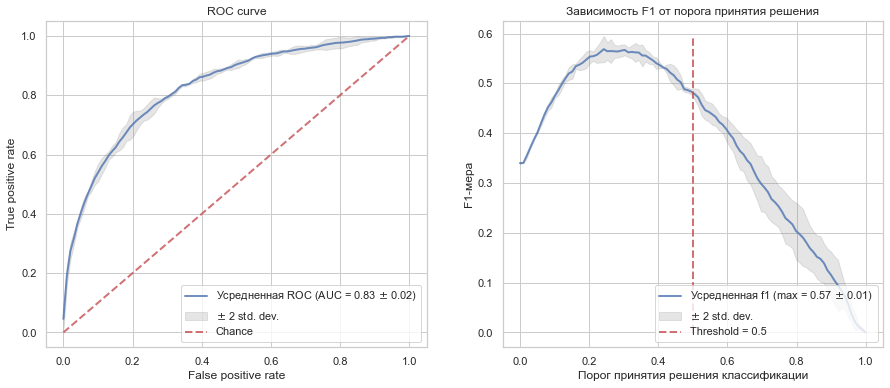

In [18]:
res = double_plot(pipe, train, n_splits=3, name='baseline')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

На левом графике изображена обычная ROC кривая, полученная на кросс-валидации и усредненная. При усреднении образовался доверительный интервал 95%, обозначенный серой областью. Штриховая линия - ROC случайного ответа.

На правом графике изображена зависимость f1-метрики от порога принятия решения, также усредненная по кросс-валидации. Вертикальная штриховая линия - порог 0.5. Как видим, он в данном случае точно не оптимален.

Будем считать эту модель бэйзлайном

F1 на валидации 0.48 - ниже, чем в ТЗ. Надо бороться.

При этом мы уже тут видим, что максимальный f1 составляет 0.57, что уже ближе к ТЗ!

## Борьба с дисбалансом

Методы борьбы с дисбалансом:
- балансирование весов классов (кроме того, апсэмплинг, но он медленнее и не дает бонусов, и даунсэмплинг, но это вообще жесть с потерей полезных данных)
- настройка порога при классификации (перебор значений порога и определение целевой метрики для каждого значения)
- выбор более подходящей модели
- настройка гиперпараметров модели

### Балансировка весами

Начнем с самого простого способа - все точно то же самое, но весами сбалансируем классы.

_model_name     f1  f1_std  f1_max  f1_max_std  threshold  \
0          baseline  0.480   0.004   0.575       0.008      0.280   
1  log balanced 0.5  0.558   0.006   0.573       0.006      0.602   

   threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0          0.051    0.663        0.002  0.839    0.002   
1          0.038    0.754        0.007  0.759    0.007   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...

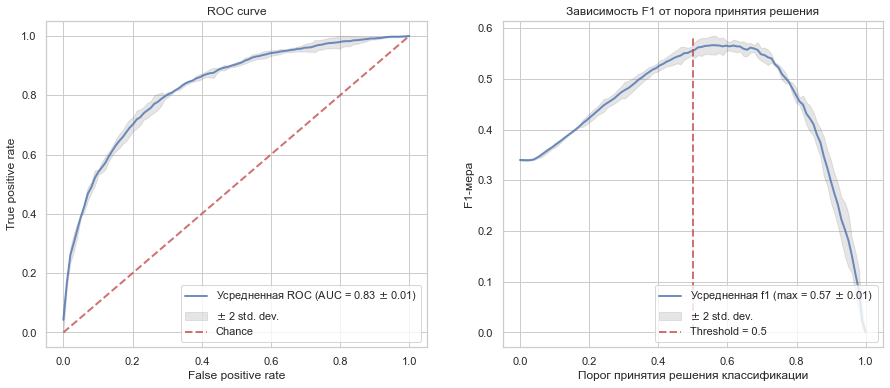

In [19]:
pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('estimator', estimator_with_threshold(
        classifier=linear_model.LogisticRegression(), 
        threshold=0.5, 
        **{'class_weight':'balanced'}
        )
    )]
)
res = double_plot(pipe, train, n_splits=3, name='log balanced 0.5')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

F1 выросла с 0,49 до 0,55.

Доля верных ответов снизилась, но нам эта метрика не нужна.

ROC AUC выросла.

Интересно, что оптимальное значение порога все равно не равно 0.5. Хотя тут сложно сказать - разброс значений слишком высок, так что может быть, реальный оптимум там и на 0.5. Но в целом из этой новой модели понятно, что после балансировки весов роль настройки порога очень сильно падает.

### Логистическая регрессия с инжинирингом признаков

В целом логично, что обычная линейная модель не справилась с задачей - на то она и линейная. Но мы можем сделать ее нелинейной, например, добавив полиномиальный трансформер в пайплайн.

Добавим сначала его только в количественные признаки.

_model_name     f1  f1_std  f1_max  f1_max_std  threshold  \
0                   baseline  0.480   0.004   0.575       0.008      0.280   
1           log balanced 0.5  0.558   0.006   0.573       0.006      0.602   
2  log poly-num balanced 0.5  0.566   0.003   0.591       0.008      0.653   

   threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0          0.051    0.663        0.002  0.839    0.002   
1          0.038    0.754        0.007  0.759    0.007   
2          0.018    0.761        0.003  0.765    0.008   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...

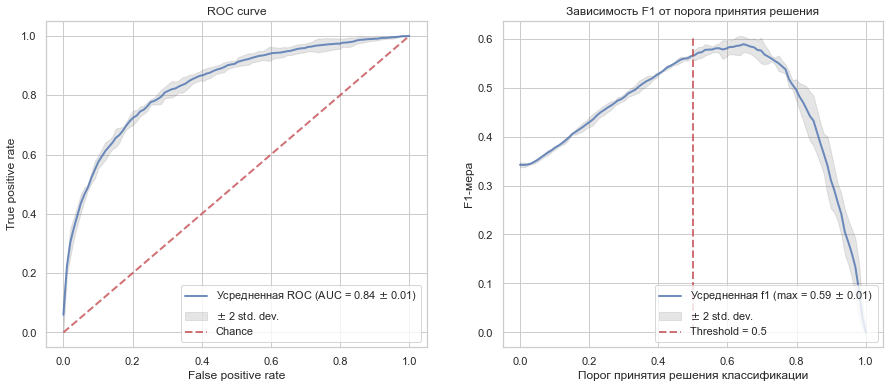

In [20]:
numeric_pipeline = make_pipeline(
    default_numeric_col_trans,
    preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False),
    preprocessing.StandardScaler()
)

data_preprocessing = make_union(
    numeric_pipeline,
    cat_union
)

pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('estimator', estimator_with_threshold(
        classifier=linear_model.LogisticRegression(), 
        threshold=0.5, 
        **{'class_weight':'balanced'}
        )
    )]
)

res = double_plot(pipe, train, n_splits=3, name='log poly-num balanced 0.5')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Вуаля - в максимуме F1 уже перешагнула через 0.59 из ТЗ. Впрочем, там большая погрешность.

Попробуем еще применить полиномиальные фичи не только к количественным признакам, а вообще ко всем. При этом мы получим огромно количество фичей (все попарные произведения), поэтому добавим еще feature_selection.SelectPercentile, чтобы избавиться от совсем уж лишних.

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...

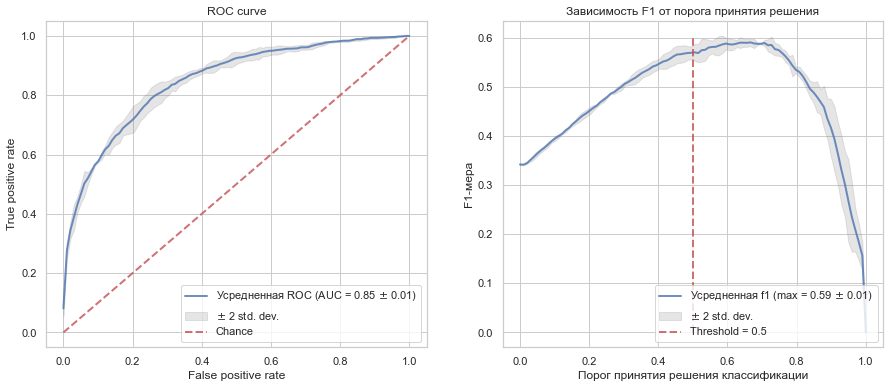

In [21]:
numeric_pipeline = make_pipeline(
    default_numeric_col_trans,
)

data_preprocessing = make_union(
    numeric_pipeline,
    cat_union
)

pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('poly', preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ('scaler', preprocessing.StandardScaler()),
    ('selector', feature_selection.SelectPercentile(percentile=75)),
    ('estimator', estimator_with_threshold(
        classifier=linear_model.LogisticRegression(), 
        threshold=0.5, 
        **{'class_weight':'balanced'}
        )
    )
    ]
)

res = double_plot(pipe, train, n_splits=3, name='log poly-all select-75 balanced 0.5')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Выжали из линейной модели еще долю процента! Но дальше идти вручную уже тяжело - в модели появляются "емкие" параметры (количество степеней полинома, процентиль выбора фич, коэффициент регуляризации), и их надо оптимизировать. Поэтому попробуем вкорячить сюда случайный поиск оптимальных параметров.

(Даже в линейной модели поиск занимает много времени, поэтому я нашел параметры заранее и вписал сюда).

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   
4                     log RandSearchCV  0.597   0.010   0.604       0.012   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   
4      0.649          0.021    0.756        0.010  0.824    0.001   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...  
4  (FeatureUnion(transformer_list=[('pipeline',\n...

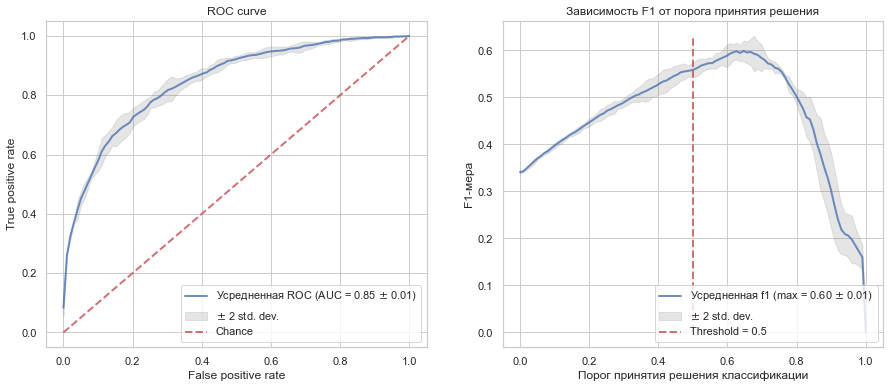

In [22]:
n_jobs = -1

if is_final == False:
    parameters = {
        'poly__degree': [2],
        'poly__interaction_only': [True, False],
        'estimator__classifier__C': np.logspace(-2, 2, num=10),
        'selector__percentile': np.linspace(40, 100, 80),
        'estimator__classifier__solver': ['liblinear'],
        'estimator__classifier__class_weight': ['balanced'],
        'estimator__threshold': np.linspace(0.57, 0.65, 50)
    }

    cv = model_selection.StratifiedKFold(n_splits=3)

    param_cv = model_selection.RandomizedSearchCV(
        pipe, parameters, scoring='f1', cv=cv, n_jobs=n_jobs, 
        error_score=0.0, refit=True, n_iter=n_iter, random_state=random_state
        )
    param_cv.fit(train[features], train[targets])
    res = double_plot(param_cv.best_estimator_, train, n_splits=3, name='log RandSearchCV')
    print(param_cv.best_params_)

else:
    parameters = {'selector__percentile': 43.79746835443038, 
                  'poly__interaction_only': False, 
                  'poly__degree': 2, 
                  'estimator__threshold': 0.6402040816326531, 
                  'estimator__classifier__solver': 'liblinear', 
                  'estimator__classifier__class_weight': 'balanced', 
                  'estimator__classifier__C': 12.915496650148826}
    pipe.set_params(**parameters)
    res = double_plot(pipe, train, n_splits=3, name='log RandSearchCV')
    
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Заметим, что в поиске мы подбирали среди прочего и параметр threshold, то есть, казалось бы, величины f1 и f1_max должны быть одинаковыми. Но они оказываются чуть разными из-за разных методи расчета. Впрочем, в пределах даже одного std все сходится.

В результате мы на кросс-валидации получили метрику f1 более 0.59.

Проверим на тесте

In [23]:
pipe.fit(train[features], train[targets])
a = pipe.predict(test[features])
metrics.f1_score(test[targets], a).round(4)

0.6201

Вероятно, стоит поискать что-то лучшее, чем линейная модель.

### Случайный лес

Начнем с того же бэйзлайн пайплайна, только поставим в качестве эстиматора случайный лес и сразу зададим ему сбалансировать веса классов. Всякие препроцессинги уберем - для деревьев они не нужны.

In [24]:
categorical_columns = [geography, gender, numofproducts, hascrcard, isactivemember]
numerical_columns = [tenure, balance, estimatedsalary, age, creditscore]

pure_category_col_trans = make_column_transformer(
    (preprocessing.OneHotEncoder(drop='first'), categorical_columns)
)

cat_union = make_union(
    pure_category_col_trans,
)

default_numeric_col_trans = make_column_transformer(
    (impute.SimpleImputer(strategy='mean', add_indicator=False), numerical_columns)
)

numeric_pipeline = make_pipeline(
    default_numeric_col_trans,
)

data_preprocessing = make_union(
    numeric_pipeline,
    cat_union
)

pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('estimator', estimator_with_threshold(
        classifier=ensemble.RandomForestClassifier(),
        threshold=0.5, 
        **{'class_weight':'balanced_subsample', 'random_state': random_state}
        )
    )]
)
#pipe

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   
4                     log RandSearchCV  0.597   0.010   0.604       0.012   
5                       RF default 0.5  0.545   0.016   0.614       0.012   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   
4      0.649          0.021    0.756        0.010  0.824    0.001   
5      0.320          0.043    0.696        0.009  0.856    0.003   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...  
4  (FeatureUnion(transformer_list=[('pipeline',\n...  
5  (FeatureUnion(transformer_list=[('pipeline',\n...

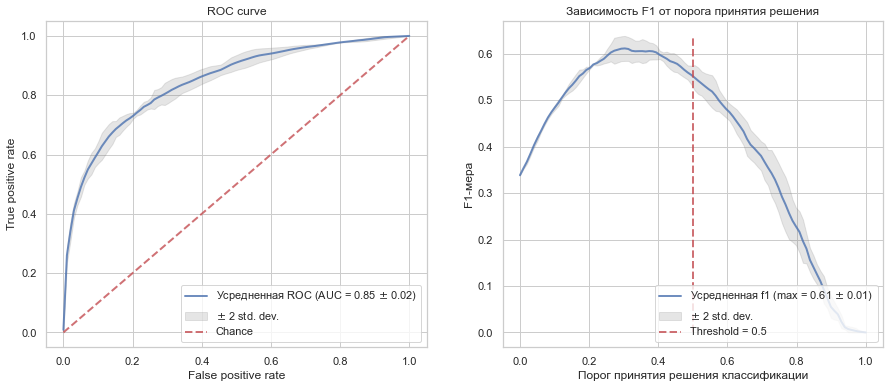

In [25]:
res = double_plot(pipe, train, n_splits=3, name='RF default 0.5')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Сходу получили результат лучше, чем на линейной модели. Хотя интересно, что roc auc стала меньше.

Теперь оптимальное пороговое значение ниже 0.5.

У леса много гиперпараметров, и их надо подбирать.

Опять же - подбор был долгим, поэтому здесь я оставил уже найденные параметры, а рабочий код закомментировал.

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   
4                     log RandSearchCV  0.597   0.010   0.604       0.012   
5                       RF default 0.5  0.545   0.016   0.614       0.012   
6                      RF RandSearchCV  0.620   0.011   0.625       0.011   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   
4      0.649          0.021    0.756        0.010  0.824    0.001   
5      0.320          0.043    0.696        0.009  0.856    0.003   
6      0.447          0.019    0.772        0.007  0.833    0.007   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...  
4  (FeatureUnion(transformer_list=[('pipeline',\n...  
5  (FeatureUnion(transformer_list=[('pipeline',\n...  
6  (FeatureUnion(transformer_list=[('pipeline',\n...

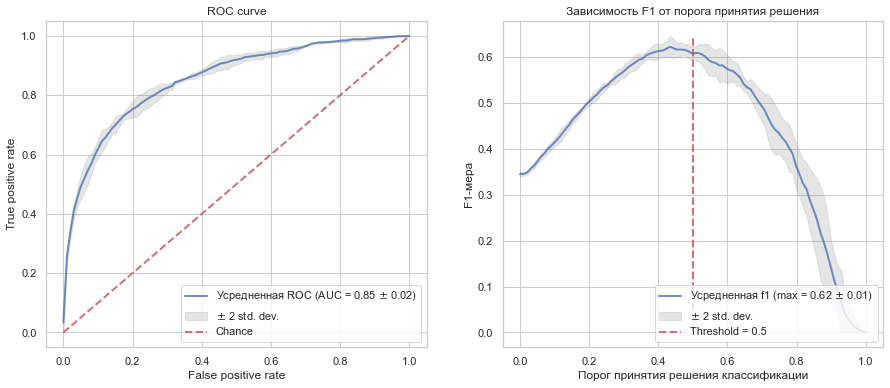

In [26]:
n_jobs = -1

if is_final == False:
    #pipe.get_params().keys()
    parameters = {
        'estimator__classifier__n_estimators': np.arange(50, 150, 10),
        'estimator__classifier__max_depth': np.arange(2, 16, 2),
        'estimator__classifier__min_samples_split': np.arange(2, 10, 2),
        'estimator__classifier__min_samples_leaf': np.arange(1, 5, 1),
        'estimator__classifier__class_weight': ['balanced', 'balanced_subsample'],
        'estimator__classifier__oob_score': [True],
        'estimator__threshold': np.linspace(0.4, 0.6, 50),
    }

    cv = model_selection.StratifiedKFold(n_splits=3)

    param_cv = model_selection.RandomizedSearchCV(
        pipe, parameters, scoring='f1', cv=cv, n_jobs=n_jobs, 
        error_score=0.0, refit=True, n_iter=n_iter, random_state=random_state
        )
    param_cv.fit(train[features], train[targets])
    res = double_plot(param_cv.best_estimator_, train, n_splits=3, name='RF RandSearchCV')
    print(param_cv.best_params_)

else:
    parameters = {'estimator__threshold': 0.4285714285714286, 
                  'estimator__classifier__oob_score': True, 
                  'estimator__classifier__n_estimators': 130, 
                  'estimator__classifier__min_samples_split': 8, 
                  'estimator__classifier__min_samples_leaf': 2, 
                  'estimator__classifier__max_depth': 14, 
                  'estimator__classifier__class_weight': 'balanced'}
    pipe.set_params(**parameters)
    res = double_plot(pipe, train, n_splits=3, name='RF RandSearchCV')
    
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Пока что лучший результат.

Посмотрим на важность предикторов. Для этого используем матрицу пермутаций.

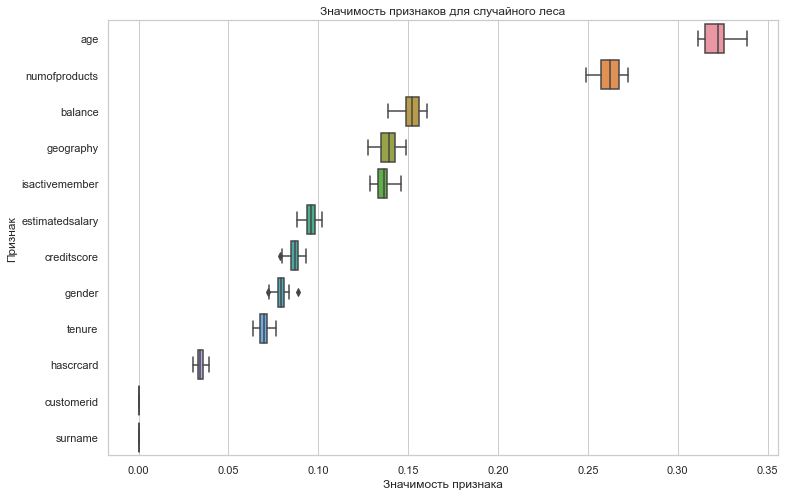

In [27]:
pipe.fit(train[features], train[targets])
a = inspection.permutation_importance(
    pipe, 
    train[features], train[targets], 
    scoring=['f1'], n_repeats=40, n_jobs=-1, random_state=random_state)
b = pd.DataFrame(a['f1']['importances'])
b['mean'] = b.mean(axis=1)
b['feature_name'] = train[features].columns
b = b.melt(id_vars=['feature_name', 'mean']).sort_values(by='mean', ascending=False)
ax = sns.boxplot(data=b, y='feature_name', x='value')
ax.set(xlabel='Значимость признака', ylabel='Признак',
       title='Значимость признаков для случайного леса');

Можно сделать вывод, что все признаки важные - важность каждого из них лежит достаточно далеко от нуля (можно было бы еще Т-тестом проверять, но не будем), то есть каждый повышает f1-меру.

Запомним, что hascrcard имеет минимальную полезность.

### Градиентный бустинг и улучшение оптимизации

Почти наверняка лучший результат мы получим с использованием алгоритма градиентного бустинга. Но стоит подумать об использовании более эффективного алгоритма оптимизации гиперпараметров, чем встроенный в sklearn. Например, попробуем optuna.

### XGBoost

Начнем с классики. Сделаем минималистичный пайплайн без лишних обработок - для деревьев они по идее не нужны.

После первого удачного запуска всего скрипта я обнаружил, что один из признаков - hascrcard - бесполезен для этого алгоритма (см. картинку). Поэтому удалим его из пайплайна.
<img src="http://dl4.joxi.net/drive/2022/01/27/0051/1752/3356376/76/aaee813a89.jpg">

In [28]:
categorical_columns = [geography, gender, numofproducts, isactivemember]
numerical_columns = [tenure, balance, estimatedsalary, age, creditscore]

pure_category_col_trans = make_column_transformer(
    (preprocessing.OneHotEncoder(drop='first'), categorical_columns)
)

zero_balance_col_trans = make_column_transformer(
    (preprocessing.FunctionTransformer(lambda x: x == 0), [balance]),
)

missing_tenure_col_trans = make_column_transformer(
    (preprocessing.FunctionTransformer(lambda x: x.isna()), [tenure]),
)

cat_union = make_union(
    pure_category_col_trans,
)

default_numeric_col_trans = make_column_transformer(
    (impute.SimpleImputer(strategy='mean', add_indicator=False), numerical_columns)
)

numeric_pipeline = make_pipeline(
    default_numeric_col_trans,
)

data_preprocessing = make_union(
    numeric_pipeline,
    cat_union
)

pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('estimator', estimator_with_threshold(
        classifier=xgb.XGBClassifier(),
        )
    )
    ], memory=cachedir
)

Теперь функция для оптуны.

Так и не понял, как подключить Pruner, чтобы он работал...

In [29]:
def objective(trial):
    global train
    global cachedir
    n_splits = 3
    global pipe
    
    params = {'estimator__threshold': trial.suggest_float("estimator__threshold", 0.2, 0.8),
        'estimator__classifier__scale_pos_weight': trial.suggest_float("estimator__classifier__scale_pos_weight", 1/10, 10), 
        'estimator__classifier__n_estimators': trial.suggest_int("estimator__classifier__n_estimators", 20, 150),
        'estimator__classifier__max_depth': trial.suggest_int("estimator__classifier__max_depth", 3, 8),
        'estimator__classifier__subsample': trial.suggest_float("estimator__classifier__subsample", 0.55, 0.95), 
        "estimator__classifier__eta": trial.suggest_float("estimator__classifier__eta", 1e-2, 1.0, log=True),
        "estimator__classifier__lambda": trial.suggest_float("estimator__classifier__lambda", 1e-8, 1.0, log=True),
        "estimator__classifier__alpha": trial.suggest_float("estimator__classifier__alpha", 1e-8, 1.0, log=True),
        "estimator__classifier__min_child_weight": trial.suggest_float("estimator__classifier__min_child_weight", 1e-8, 10, log=True),
        'estimator__classifier__random_state': random_state,"estimator__classifier__objective": "binary:logistic",
        "estimator__classifier__eval_metric": "auc",
        "estimator__classifier__booster": "gbtree",
        }
    
    pipe.set_params(**params)
    #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-f1")
    cv = model_selection.StratifiedKFold(n_splits=n_splits)
    a = model_selection.cross_validate(pipe, train[features], train[targets], scoring='f1', cv=cv)
    a = a['test_score']
    
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return np.mean(a)

Подбор гиперпараметров.

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   
4                     log RandSearchCV  0.597   0.010   0.604       0.012   
5                       RF default 0.5  0.545   0.016   0.614       0.012   
6                      RF RandSearchCV  0.620   0.011   0.625       0.011   
7                       XGBoost optuna  0.622   0.003   0.632       0.004   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   
4      0.649          0.021    0.756        0.010  0.824    0.001   
5      0.320          0.043    0.696        0.009  0.856    0.003   
6      0.447          0.019    0.772        0.007  0.833    0.007   
7      0.594          0.033    0.765        0.002  0.842    0.004   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...  
4  (FeatureUnion(transformer_list=[('pipeline',\n...  
5  (FeatureUnion(transformer_list=[('pipeline',\n...  
6  (FeatureUnion(transformer_list=[('pipeline',\n...  
7  (FeatureUnion(transformer_list=[('pipeline',\n...

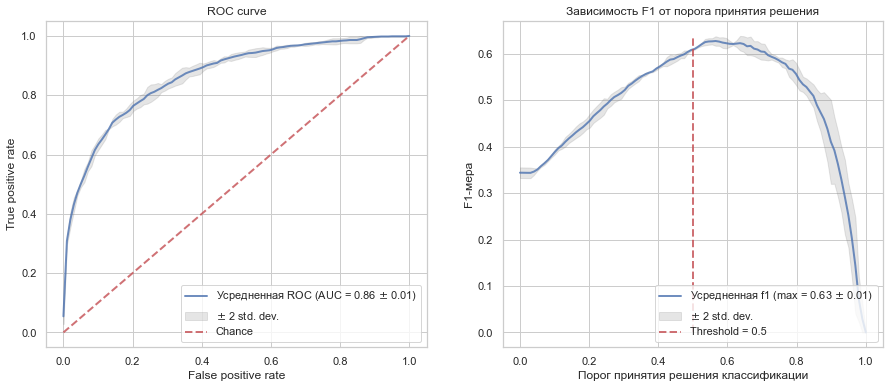

In [30]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

if is_final == False:
    pruner = pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, n_warmup_steps=30, interval_steps=10
        )
    study = optuna.create_study(pruner=pruner, direction="maximize")
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    print("Количество запусков: {}".format(len(study.trials)))

    print("Лучший результат:")
    trial = study.best_trial
    print("  f1: {}".format(trial.value))
        
    fig_list = [
            optuna.visualization.plot_optimization_history(study),
            optuna.visualization.plot_param_importances(study),
        ]
    for fig in fig_list:
        fig.update_layout(width=1000)
        fig.show()
    trial = study.best_trial
    parameters = trial.params
    print(parameters)
    
else:
    parameters = {'estimator__threshold': 0.6059370218897372, 
                  'estimator__classifier__scale_pos_weight': 3.8130877566390176, 
                  'estimator__classifier__n_estimators': 62, 
                  'estimator__classifier__max_depth': 3, 
                  'estimator__classifier__subsample': 0.9098649365891014, 
                  'estimator__classifier__eta': 0.15814728127496777, 
                  'estimator__classifier__lambda': 1.8774747867787233e-08, 
                  'estimator__classifier__alpha': 0.004185985231147195, 
                  'estimator__classifier__min_child_weight': 2.8611988696548625e-07}
    
pipe.set_params(**parameters)
res = double_plot(pipe, train, n_splits=3, name='XGBoost optuna')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

Результат практически не отличается от случайного леса.

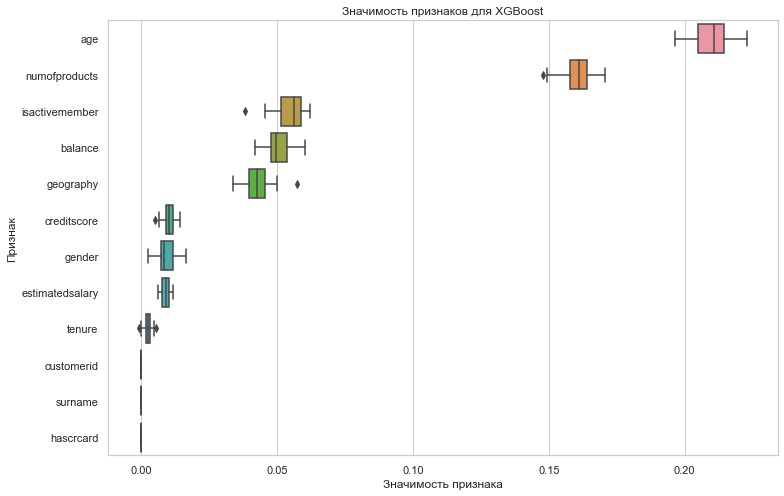

In [31]:
pipe.fit(train[features], train[targets])
a = inspection.permutation_importance(
    pipe, 
    train[features], train[targets], 
    scoring=['f1'], n_repeats=40, n_jobs=-1, random_state=random_state)
b = pd.DataFrame(a['f1']['importances'])
b['mean'] = b.mean(axis=1)
b['feature_name'] = train[features].columns
b = b.melt(id_vars=['feature_name', 'mean']).sort_values(by='mean', ascending=False)
ax = sns.boxplot(data=b, y='feature_name', x='value')
ax.set(xlabel='Значимость признака', ylabel='Признак',
       title='Значимость признаков для XGBoost');

Оставшиеся признаки вполне значимы. По смыслу интересно, что tenure и gender и тут, и в случайном лесу имеют минимальную полезность, хотя я бы предположил, что они должны быть очень значимыми.

### LightGBM

Еще не пробовал работать с этой библиотекой. Попробуем. Делаем такой же пайплайн.

In [32]:
categorical_columns = [geography, gender, numofproducts, isactivemember]
numerical_columns = [tenure, balance, estimatedsalary, age, creditscore]

pure_category_col_trans = make_column_transformer(
    (preprocessing.OneHotEncoder(drop='first'), categorical_columns)
)

zero_balance_col_trans = make_column_transformer(
    (preprocessing.FunctionTransformer(lambda x: x == 0), [balance]),
)

missing_tenure_col_trans = make_column_transformer(
    (preprocessing.FunctionTransformer(lambda x: x.isna()), [tenure]),
)

cat_union = make_union(
    pure_category_col_trans,
)

default_numeric_col_trans = make_column_transformer(
    (impute.SimpleImputer(strategy='mean', add_indicator=False), numerical_columns)
)

numeric_pipeline = make_pipeline(
    default_numeric_col_trans,
)

data_preprocessing = make_union(
    numeric_pipeline,
    cat_union
)

pipe = pipeline.Pipeline([
    ('data_preprocessing', data_preprocessing),
    ('estimator', estimator_with_threshold(
        classifier=lgb.LGBMClassifier(),
        )
    )
    ], memory=cachedir
)

Обучаем

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   
4                     log RandSearchCV  0.597   0.010   0.604       0.012   
5                       RF default 0.5  0.545   0.016   0.614       0.012   
6                      RF RandSearchCV  0.620   0.011   0.625       0.011   
7                       XGBoost optuna  0.622   0.003   0.632       0.004   
8                           LGB optuna  0.636   0.004   0.638       0.004   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   
4      0.649          0.021    0.756        0.010  0.824    0.001   
5      0.320          0.043    0.696        0.009  0.856    0.003   
6      0.447          0.019    0.772        0.007  0.833    0.007   
7      0.594          0.033    0.765        0.002  0.842    0.004   
8      0.603          0.034    0.778        0.003  0.845    0.004   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...  
4  (FeatureUnion(transformer_list=[('pipeline',\n...  
5  (FeatureUnion(transformer_list=[('pipeline',\n...  
6  (FeatureUnion(transformer_list=[('pipeline',\n...  
7  (FeatureUnion(transformer_list=[('pipeline',\n...  
8  (FeatureUnion(transformer_list=[('pipeline',\n...

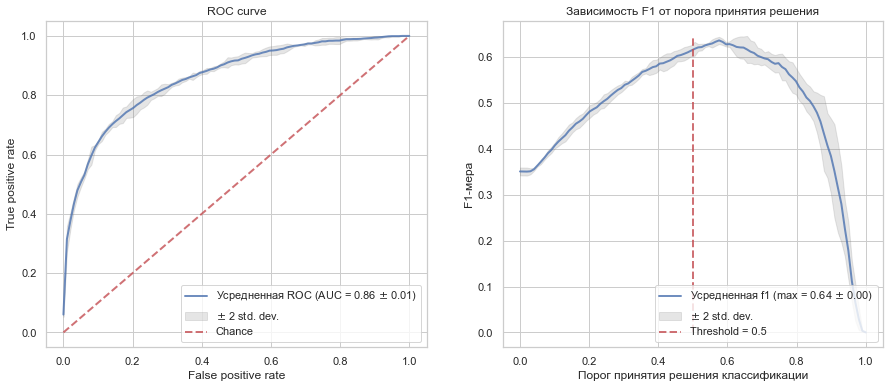

In [33]:
if is_final == False:
    param_distributions = {
        "estimator__threshold": optuna.distributions.UniformDistribution(0.1, 0.9),
        'estimator__classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.55, 1), 
        'estimator__classifier__learning_rate': optuna.distributions.LogUniformDistribution(1e-3, 1), 
        'estimator__classifier__max_depth': optuna.distributions.IntUniformDistribution(2, 12), 
        'estimator__classifier__min_child_samples': optuna.distributions.IntUniformDistribution(10, 30), 
        'estimator__classifier__min_child_weight': optuna.distributions.LogUniformDistribution(1e-4, 1e-2), 
        'estimator__classifier__min_split_gain': optuna.distributions.UniformDistribution(0.0, 0.3), 
        'estimator__classifier__n_estimators': optuna.distributions.IntUniformDistribution(60, 300), 
        'estimator__classifier__num_leaves': optuna.distributions.IntUniformDistribution(15, 60), 
        'estimator__classifier__random_state': optuna.distributions.IntUniformDistribution(random_state, random_state), 
        'estimator__classifier__reg_alpha': optuna.distributions.LogUniformDistribution(1e-6, 10), 
        'estimator__classifier__reg_lambda': optuna.distributions.LogUniformDistribution(1e-6, 10), 
        'estimator__classifier__subsample': optuna.distributions.UniformDistribution(0.55, 1), 
        'estimator__classifier__is_unbalance': optuna.distributions.CategoricalDistribution([True]),
        }

    optuna_search = optuna.integration.OptunaSearchCV(
        pipe,
        param_distributions,
        cv=model_selection.StratifiedKFold(n_splits=3),
        n_trials=n_trials,
        timeout=timeout,
        random_state=random_state,
        scoring='f1',
        n_jobs=-1,
        )
    optuna_search.fit(train[features], train[targets])

    print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
    print("Лучший результат:")
    trial = optuna_search.study_.best_trial
    print("  f1: {}".format(trial.value))
    parameters = optuna_search.best_params_
    print(parameters)

else:
    parameters = {'estimator__threshold': 0.577812659716527, 
                  'estimator__classifier__colsample_bytree': 0.6560623294625185, 
                  'estimator__classifier__learning_rate': 0.04464713509989089, 
                  'estimator__classifier__max_depth': 12, 
                  'estimator__classifier__min_child_samples': 23, 
                  'estimator__classifier__min_child_weight': 0.0012002202865099645, 
                  'estimator__classifier__min_split_gain': 0.21253307816662143, 
                  'estimator__classifier__n_estimators': 118, 
                  'estimator__classifier__num_leaves': 33, 
                  'estimator__classifier__random_state': 2077, 
                  'estimator__classifier__reg_alpha': 0.0033075151009228356, 
                  'estimator__classifier__reg_lambda': 0.00042847806387666794, 
                  'estimator__classifier__subsample': 0.9792704432173722, 
                  'estimator__classifier__is_unbalance': True}
    
pipe.set_params(**parameters)
res = double_plot(pipe, train, n_splits=3, name='LGB optuna')
result = result.append(res, ignore_index=True).drop_duplicates()
display(result)

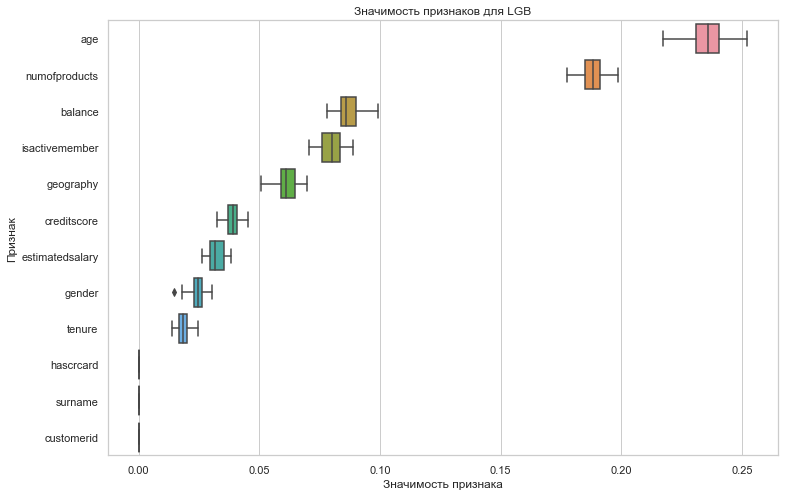

In [34]:
pipe.fit(train[features], train[targets])
a = inspection.permutation_importance(
    pipe, 
    train[features], train[targets], 
    scoring=['f1'], n_repeats=40, n_jobs=-1, random_state=random_state)
b = pd.DataFrame(a['f1']['importances'])
b['mean'] = b.mean(axis=1)
b['feature_name'] = train[features].columns
b = b.melt(id_vars=['feature_name', 'mean']).sort_values(by='mean', ascending=False)
ax = sns.boxplot(data=b, y='feature_name', x='value')
ax.set(xlabel='Значимость признака', ylabel='Признак',
       title='Значимость признаков для LGB');

В целом результат не особо отличается от остальных классификаторов на основе градиентного бустинга. Но, кажется, расчеты идут быстрее.

Посмотрим еще раз на таблицу с результатам и перейдем к промежуточному выводу.

In [35]:
result

_model_name     f1  f1_std  f1_max  f1_max_std  \
0                             baseline  0.480   0.004   0.575       0.008   
1                     log balanced 0.5  0.558   0.006   0.573       0.006   
2            log poly-num balanced 0.5  0.566   0.003   0.591       0.008   
3  log poly-all select-75 balanced 0.5  0.572   0.008   0.598       0.002   
4                     log RandSearchCV  0.597   0.010   0.604       0.012   
5                       RF default 0.5  0.545   0.016   0.614       0.012   
6                      RF RandSearchCV  0.620   0.011   0.625       0.011   
7                       XGBoost optuna  0.622   0.003   0.632       0.004   
8                           LGB optuna  0.636   0.004   0.638       0.004   

   threshold  threshold_std  roc_auc  roc_auc_std    acc  acc_std  \
0      0.280          0.051    0.663        0.002  0.839    0.002   
1      0.602          0.038    0.754        0.007  0.759    0.007   
2      0.653          0.018    0.761        0.003  0.765    0.008   
3      0.658          0.053    0.763        0.010  0.771    0.002   
4      0.649          0.021    0.756        0.010  0.824    0.001   
5      0.320          0.043    0.696        0.009  0.856    0.003   
6      0.447          0.019    0.772        0.007  0.833    0.007   
7      0.594          0.033    0.765        0.002  0.842    0.004   
8      0.603          0.034    0.778        0.003  0.845    0.004   

                                           estimator  
0  (FeatureUnion(transformer_list=[('pipeline',\n...  
1  (FeatureUnion(transformer_list=[('pipeline',\n...  
2  (FeatureUnion(transformer_list=[('pipeline',\n...  
3  (FeatureUnion(transformer_list=[('pipeline',\n...  
4  (FeatureUnion(transformer_list=[('pipeline',\n...  
5  (FeatureUnion(transformer_list=[('pipeline',\n...  
6  (FeatureUnion(transformer_list=[('pipeline',\n...  
7  (FeatureUnion(transformer_list=[('pipeline',\n...  
8  (FeatureUnion(transformer_list=[('pipeline',\n...

### Выводы по результатам борьбы с дисбалансом

- введение балансировки классов весами значительно снижает чувствительность результата (f1-меры) к выбору порогового значения, однако эта чувствительность все равно остается, и оптимальное значение порога во всех случаях отличается от 0.5
- линейная модель с полиномиальными комбинациями признаков позволила достичь требуемого значения f1 (0.59) на кросс-валидации
- все алгоритмы на основе ансамблей решающих деревьев позволили добиться значения f1 около 0.62 на кросс-валидации
- можно взять лучшие алгоритмы и проверить результат на отложенной выборке

### Стекинг

Попробуем объединить лучшие модели.

Гиперпараметры каждой модели уже настроены по кросс-валидации. Кросс-валидация также встроена и в сам StackingClassifier.

Тут есть некоторая проблема - каждый классификатор натренирован со своим порогом. Поэтому метод predict_proba у всех будет смещен по-разному, и мы не можем использовать "мягкое" суммирование классификаторов. Поэтому будем использовать обычное жесткое голосование.

In [36]:
a = result.sort_values(by='f1', ascending=False).head(3)
b = zip(
    a['_model_name'],
    a['estimator']
)
c = list(b)

stack = ensemble.StackingClassifier(
    c,
    final_estimator=linear_model.LogisticRegression(),
    stack_method='predict',
    cv=model_selection.StratifiedKFold(n_splits=3)
)

f1_cv = model_selection.cross_validate(
    stack,
    train[features], train[targets],
    scoring='f1',
    cv=model_selection.StratifiedKFold(n_splits=3),
)
res = {'_model_name': 'stacked',
       'estimator': stack}
result = result.append(res, ignore_index=True).drop_duplicates()
#stack

## Тестирование модели

Итак, у нас готов ряд моделей с оценками их F1-мер на кросс-валидации. Теперь проверим их все на отложенной выборке.

In [37]:
results = []
for i in result.index:
    row = result.iloc[i,:]
    name = row["_model_name"]
    clf = clone(row["estimator"])
    cv_scores = model_selection.cross_validate(
        clf,
        train[features], train[targets],
        scoring=['f1', 'roc_auc'],
        cv=model_selection.StratifiedKFold(n_splits=3),
    )
    f1_cv = cv_scores['test_f1'].mean()
    roc_auc_cv = cv_scores['test_roc_auc'].mean()
    
    clf.fit(train[features], train[targets])
    pred = clf.predict(test[features])
    f1_test = metrics.f1_score(test[targets], pred)
    roc_auc_test = metrics.roc_auc_score(test[targets], pred)
    
    res = {
        'Модель': name,
        'кросс-вал_f1': f1_cv,
        'тест_f1': f1_test,
        'кросс-вал_roc_auc': roc_auc_cv,
        'тест_roc_auc': roc_auc_test
           }
    results.append(res)

In [38]:
plot_df_base = pd.DataFrame()
for i in results:
    plot_df_base = plot_df_base.append(i, ignore_index=True)
plot_df_base

Модель  кросс-вал_f1   тест_f1  \
0                             baseline      0.480250  0.504436   
1                     log balanced 0.5      0.557666  0.570387   
2            log poly-num balanced 0.5      0.566369  0.574946   
3  log poly-all select-75 balanced 0.5      0.571539  0.586285   
4                     log RandSearchCV      0.597347  0.620127   
5                       RF default 0.5      0.545175  0.599755   
6                      RF RandSearchCV      0.619935  0.629565   
7                       XGBoost optuna      0.621535  0.641121   
8                           LGB optuna      0.636238  0.625000   
9                              stacked      0.619827  0.639684   

   кросс-вал_roc_auc  тест_roc_auc  
0           0.828415      0.675140  
1           0.829595      0.765804  
2           0.837716      0.770694  
3           0.848227      0.774387  
4           0.845287      0.772668  
5           0.845558      0.724847  
6           0.853965      0.785534  
7           0.863607      0.782189  
8           0.859643      0.773968  
9           0.800761      0.773068

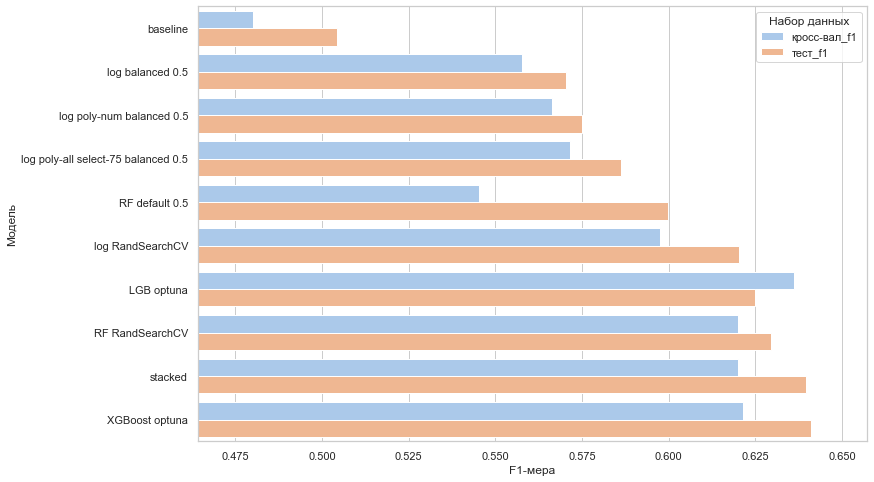

In [39]:
plot_df = plot_df_base[['Модель', 'кросс-вал_f1', 'тест_f1']]
plot_df = plot_df.sort_values(by='тест_f1')
plot_df = plot_df.melt(id_vars=['Модель'], var_name='Набор данных', value_name='F1-мера')
plop_df = plot_df.sort_values(by='F1-мера', ascending=False).reset_index(drop=True)
min_val = plot_df['F1-мера'].min()
max_val = plot_df['F1-мера'].max()
range = max_val - min_val

ax = sns.barplot(
    data=plot_df,
    x='F1-мера',
    y='Модель',
    hue='Набор данных',
)
ax.set(xlim=(min_val - range * 0.1, max_val + range * 0.1));

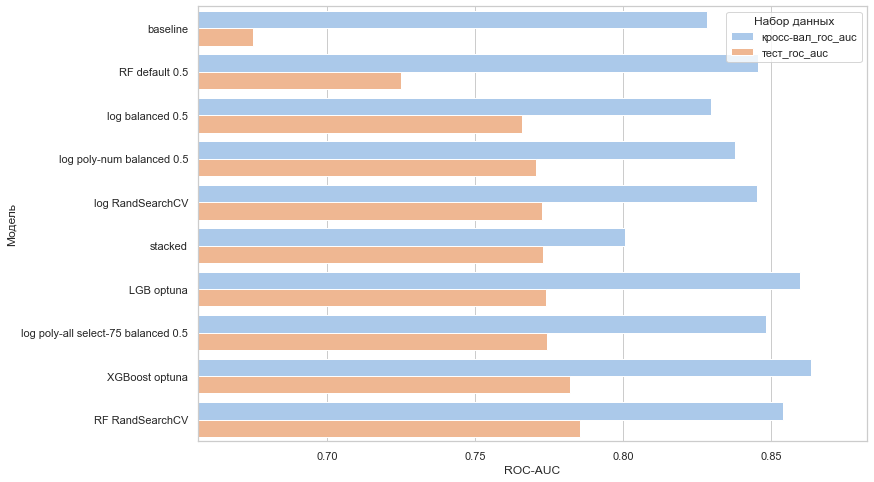

In [40]:
plot_df = plot_df_base[['Модель', 'кросс-вал_roc_auc', 'тест_roc_auc']]
plot_df = plot_df.sort_values(by='тест_roc_auc')
plot_df = plot_df.melt(id_vars=['Модель'], var_name='Набор данных', value_name='ROC-AUC')
plop_df = plot_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
min_val = plot_df['ROC-AUC'].min()
max_val = plot_df['ROC-AUC'].max()
range = max_val - min_val

ax = sns.barplot(
    data=plot_df,
    x='ROC-AUC',
    y='Модель',
    hue='Набор данных',
)
ax.set(xlim=(min_val - range * 0.1, max_val + range * 0.1));

## Выводы

- отобраны потенциально полезные признаки
- обучена модель логистической регрессии без учета дисбаланса, результат неудовлетворительный (baseline на изображениях выше)
- обучен ряд моделей (логистическая регрессия с инжинирингом признаков, случайный лес, градиентный бустинг) с учетом дисбаланса классов. Гиперпараметры моделей подбирались случайным поиском в заданных диапазонах с проверкой на кросс-валидации
- три лучшие модели (случайный лес, XGBoost, LightGB) объединены в стек
- для всех финальных моделей определены F1 и roc auc на кросс-валидации и на отложенной тестовой выборке
- лучший результат (f1 = 0.641) на тестовой выборке показал XGBoost
- лучший результат (f1 = 0.636) на кросс-валидации показал LightGB
- очевидно, результаты на тесте и на кросс-валидации не всегда совпадают как по абсолютному значению, так и по месту в рейтинге
- исследованы метрики roc auc, их поведение сильно отличатся от f1-меры:
    - на тесте roc auc всегда значительно ниже, чем на кросс-валидации
    - места в рейтинге не совсем такие, как в рейтинге f1-меры
    - разброс абсолютных значений roc auc значительно меньше, чем разброс f1-меры

- в результате было обучено 5 моделей, f1-меры которых превышают порог, заданный в ТЗ (0.59):
    - логистическая регрессия с инжинирингом признаков
    - случайный лес
    - XGBoost
    - LightGB
    - стекинг из леса, XGBoost и LightGB

- использование стекинга в лоб не дало положительного результата - он отработал хуже одной лучшей модели. Вероятно, для него надо больше моделей и еще их как-то взвешивать

Задачи для себя на будущее:
- разобраться с прунингом в оптуне
- вкрутить catboost в pipeline, если это возможно